In [108]:
from sklearn import svm
import GPyOpt, numpy as np, seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [263]:
class ParamzSVC(Model):
    def __init__(self, X, y, C=1., gamma=1., name='ParamzSVC'):
        super(ParamzSVC, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.gamma = Param('gamma', gamma)
        self.link_parameter(self.C)
        self.link_parameter(self.gamma)
        
        self._accuracies = np.empty((10,5))
        
    def parameters_changed(self):
        from sklearn.metrics import f1_score, accuracy_score
        from sklearn.cross_validation import StratifiedKFold
    
        for i in range(self._accuracies.shape[0]):
            j = 0
            for train_index, test_index in StratifiedKFold(train_labels, shuffle=True, n_folds=self._accuracies.shape[1]):
                svc = svm.SVC(C=float(self.C.values), 
                              gamma=float(self.gamma.values), 
                              kernel='rbf', 
                              decision_function_shape='ovr', 
                              probability=False, 
                              class_weight='balanced')
                svc = svc.fit(self.X[train_index], self.y[train_index])
                prediction = svc.predict(self.X[test_index])
                #self._obj += accuracy_score(self.y[test_index], prediction)
                self._accuracies[i,j] = accuracy_score(self.y[test_index], prediction)
                j += 1
                
        self._obj = self._accuracies.mean()

        
    def objective_function(self):
        import numpy as np
        #print self._obj,
        return -np.atleast_1d(self._obj)

In [264]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [265]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [266]:
def make_f(m):
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    return f

In [272]:
train_errors = {}

for i in range(len(all_data)):
    data = all_data[i]
    print data.name
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    
    m = ParamzSVC(train_set.T.values, train_labels.values)
    
    fx_opt = m.objective_function()
    x_opt = m.param_array.copy()
    
    for C in np.arange(-5,15,2):
        for gamma in np.arange(-15, 5, 2):
            m.C = np.exp(C)
            m.gamma = np.exp(gamma)
            if m.objective_function() < fx_opt:
                    fx_opt = m.objective_function()
                    x_opt = m.param_array.copy()
    train_errors[data.name] = [fx_opt, x_opt]
    #m_opt = GPyOpt.methods.BayesianOptimization(make_f(m), 
    #                                        bounds=[
    #                                                (np.exp(-5),np.exp(15)),
    #                                                (np.exp(-15),np.exp(5))
    #                                                ], 
    #                                        model_optimize_restarts = 100,
    #                                        normalize=True,
    #                                        acquisition = 'EI',
    #                                        type_initial_design='latin')
    #print
    #m_opt.run_optimization(500, eps=1e-5)
    #print
    #train_errors[data.name] = [m_opt.fx_opt, m_opt.x_opt]

all_genes
effector_genes
mod_activities
mod_genevalues
mod_nodevalues
signaling_genes


In [273]:
train_errors

{'all_genes': [array([-0.9327381]),
  array([  1.09663316e+03,   3.05902321e-07])],
 'effector_genes': [array([-0.92321429]),
  array([  8.10308393e+03,   2.26032941e-06])],
 'mod_activities': [array([-0.90880952]),
  array([  4.42413392e+05,   6.73794700e-03])],
 'mod_genevalues': [array([-0.91440476]),
  array([  5.98741417e+04,   1.23409804e-04])],
 'mod_nodevalues': [array([-0.93369048]),
  array([  5.98741417e+04,   2.26032941e-06])],
 'signaling_genes': [array([-0.94190476]),
  array([  2.00855369e+01,   1.23409804e-04])]}

In [274]:
results = pd.DataFrame(columns=['acc', 'C', 'gamma'], 
                       index=train_errors.keys(),
                       dtype=float)
acc, cg = zip(*train_errors.values())
results['acc'] = -np.concatenate(acc)
C,g = [[_c[i] for _c in cg] for i in range(2)]
results['C'] = C
results['gamma'] = g

(0.9, 0.95)

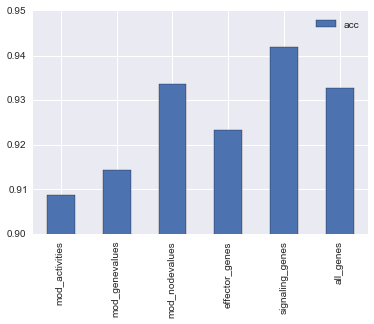

In [281]:
ax = results.plot(kind='bar', y='acc')
ax.set_ylim(0.9, .95)

In [282]:
best = results.acc.idxmax(0)
print best

signaling_genes


## Work on best training data:

In [283]:
svc = svm.SVC(C=results.loc[best, 'C'], 
                      gamma=results.loc[best, 'gamma'], 
                      kernel='rbf', 
                      decision_function_shape='ovr', 
                      probability=True, 
                      class_weight='balanced')

In [284]:
train_set, test_set = get_train_test_set(rnaseq_signaling_genes, train_idx, test_idx)
svc.fit(train_set.T.values, train_labels)

SVC(C=20.085536923187668, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00012340980408667956,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [285]:
prediction_probabilities = pd.DataFrame(svc.predict_proba(test_set.T.values), index=test_set.columns, columns=svc.classes_)

In [286]:
test_labels.value_counts()
test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

## Roc curve for each class:

In [287]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [288]:
rocs = {}
for c in prediction_probabilities.columns:
    rocs[c] = roc_curve(test_labels_collected==c, prediction_probabilities[c])

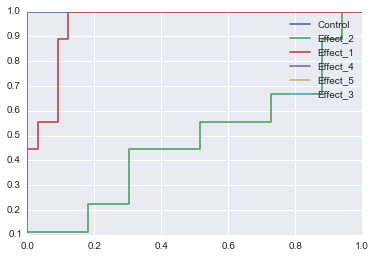

In [289]:
for name in rocs:
    plt.plot(rocs[name][0], rocs[name][1], label=name)
plt.legend()

## Try to use the predicted probabilities to find unknown classes:

In [290]:
def predict_classes(prediction_probabilities, threshold):
    import scipy
    #sort = np.argsort(prediction_probabilities, 1).values[:, ::-1]
    prediction = prediction_probabilities.idxmax(1)
    #score = prediction_probabilities.std(1)
    score = prediction_probabilities.max(1)
    prediction[score<threshold] = 'Unknown'
    return prediction

In [291]:
thresholds = np.linspace(0,1,300)
accs = pd.DataFrame(columns=['acc', 'prec', 'recall'], index=thresholds)
for t in thresholds:
    prediction = predict_classes(prediction_probabilities, t)
    accs.loc[t] = [accuracy_score(test_labels_collected, prediction), precision_score(test_labels_collected, prediction), recall_score(test_labels_collected, prediction)]

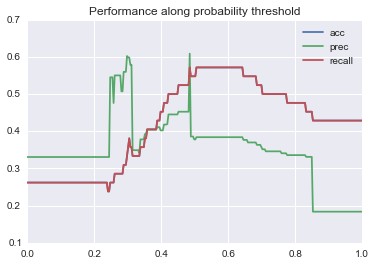

In [292]:
ax = accs.plot()
ax.set_title('Performance along probability threshold')

In [293]:
from sklearn.metrics import confusion_matrix

In [294]:
best = prediction_probabilities.idxmax(1)
score = prediction_probabilities.max(1)
best[score<accs.acc.max()] = 'Unknown'

In [296]:
best.unique(),test_labels_collected.unique()

(array(['Control', 'Unknown', 'Effect_4'], dtype=object),
 array(['Control', 'Effect_2', 'Unknown', 'Effect_1'], dtype=object))

In [297]:
print classification_report(test_labels_collected, best,)

             precision    recall  f1-score   support

    Control       1.00      1.00      1.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.56      1.00      0.72        18

avg / total       0.38      0.57      0.45        42



In [298]:
print "Best accuracy by choosing threshold = {:.0%}".format(accuracy_score(test_labels_collected, best))

Best accuracy by choosing threshold = 57%


In [299]:
_labs = test_labels_collected.unique()

In [300]:
pd.DataFrame(confusion_matrix(test_labels_collected, best, labels=_labs), index=_labs, columns=_labs)

,Control,Effect_2,Unknown,Effect_1
Control,6,0,0,0
Effect_2,0,0,5,0
Unknown,0,0,18,0
Effect_1,0,0,9,0
